In [ ]:
!pip install --quiet --upgrade pip
!pip install --quiet pandas numpy requests scikit-learn umap-learn hdbscan \
bertopic emoji datasketch keybert ruptures plotly sentence-transformers \
google-generativeai transformers torch sentencepiece gensim seaborn wordcloud networkx
!pip install --quiet pandas numpy requests scikit-learn umap-learn hdbscan bertopic emoji datasketch keybert ruptures plotly sentence-transformers google-generativeai


In [ ]:
import os, json, re, math, warnings, itertools, string
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import requests
from datetime import datetime

# Embeddings & NLP

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Topic modeling
from bertopic import BERTopic

# Outlier-resistant reduction
import umap

# Cleaning & dedupe
import emoji
from datasketch import MinHash, MinHashLSH

# Keyphrase extraction
from keybert import KeyBERT

# Change-point / burst detection
import ruptures as rpt

# Visualization
import plotly.express as px
import plotly.graph_objects as go

# LLM (GenAI)
import google.generativeai as genai

# Gensim coherence
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Environment
SEED = 42
np.random.seed(SEED)





In [ ]:
# Data source (single-line, fixed)
GITHUB_JSON_URL = "https://raw.githubusercontent.com/SumedhaArya06/Trendspotting/refs/heads/main/trend.json"

# Output paths
OUT_DIR = "outputs_hyper_trends"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(f"{OUT_DIR}/trend_json", exist_ok=True)

# Embedding model
EMBEDDING_MODEL_NAME = "all-mpnet-base-v2"

# UMAP params
UMAP_N_NEIGHBORS = 10
UMAP_MIN_DIST = 0.1
UMAP_METRIC = "cosine"

# BERTopic params
BERTOPIC_MIN_TOPIC_SIZE = 8
BERTOPIC_VECTORIZER = CountVectorizer(ngram_range=(1,2), min_df=2, stop_words="english")

# KMeans search space
KMEANS_K_RANGE = list(range(6, 21))  # try 6..20 clusters

# LLM model preference
def list_available_models():
    try:
        return [m.name for m in genai.list_models() if "generateContent" in getattr(m, "supported_generation_methods", [])]
    except Exception as e:
        print("Could not list models:", e)
        return []

def pick_gemini_model(preferred=("gemini-1.5-flash-002","gemini-1.5-flash-latest","gemini-1.5-pro-002")):
    models = list_available_models()
    for p in preferred:
        if any(p in m for m in models):
            return p
    return "gemini-1.5-flash-latest"

GEMINI_MODEL_NAME = pick_gemini_model()
print("Using Gemini model:", GEMINI_MODEL_NAME)

Using Gemini model: gemini-1.5-flash-latest


In [ ]:
# Load data
resp = requests.get(GITHUB_JSON_URL, timeout=30)
resp.raise_for_status()
raw = resp.json()

# Unwrap potential wrappers
if isinstance(raw, dict) and 'trend' in raw:
    records = raw['trend']
elif isinstance(raw, dict) and 'skincare_data' in raw:
    records = raw['skincare_data']
elif isinstance(raw, list):
    records = raw
else:
    records = [raw]

df = pd.DataFrame(records)

# Expand nested skincare_data if present
if 'skincare_data' in df.columns and df['skincare_data'].map(type).eq(dict).all():
    df = pd.json_normalize(df['skincare_data'])

# Ensure columns
for col in ['id','type','platform','text','date','rating','verified_purchase','source','author',
            'engagement.likes','engagement.comments','engagement.retweets','engagement.shares']:
    if col not in df.columns:
        df[col] = np.nan

# Types & cleaning
df['text'] = df['text'].fillna("").astype(str)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
for col in ['engagement.likes','engagement.comments','engagement.retweets','engagement.shares','rating']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def clean_text(s: str) -> str:
    s = emoji.replace_emoji(s or "", replace='')
    s = s.translate(str.maketrans('', '', string.punctuation.replace('-', '')))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df = df[df['text_clean'].str.len() > 0].reset_index(drop=True)

# Engagement (fill NaNs with 0)
df['engagement_sum'] = df[['engagement.likes','engagement.comments','engagement.retweets','engagement.shares']].fillna(0).sum(axis=1)

print("Loaded records:", len(df))
df[['text','text_clean']].head(3)


Loaded records: 147


,text,text_clean
0,Obsessed with slugging! My skin has never been...,Obsessed with slugging My skin has never been ...
1,Ceramides are literally saving my damaged skin...,Ceramides are literally saving my damaged skin...
2,Skin cycling routine: retinol → exfoliate → re...,Skin cycling routine retinol → exfoliate → rec...


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

SENT_MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"
try:
    tok = AutoTokenizer.from_pretrained(SENT_MODEL)
    mod = AutoModelForSequenceClassification.from_pretrained(SENT_MODEL)
    senti_pipe = pipeline("sentiment-analysis", model=mod, tokenizer=tok, truncation=True, max_length=256)

    def sent_score(text):
        out = senti_pipe(text[:500])[0]
        label = out['label'].lower()  # 'positive'/'neutral'/'negative'
        score = out['score']
        # Map to [-1, 1]
        return {"positive": score, "neutral": 0.0, "negative": -score}.get(label, 0.0)

    df['sentiment_score'] = df['text_clean'].apply(sent_score)
except Exception as e:
    print("Sentiment model failed, defaulting to 0:", e)
    df['sentiment_score'] = 0.0


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [ ]:
from datasketch import MinHash, MinHashLSH

def to_minhash(text, num_perm=64):
    m = MinHash(num_perm=num_perm)
    for token in set(re.findall(r'\w+', text.lower())):
        m.update(token.encode('utf8'))
    return m

lsh = MinHashLSH(threshold=0.85, num_perm=64)
keep_idx = []
for i, t in enumerate(df['text_clean']):
    m = to_minhash(t)
    if not lsh.query(m):
        lsh.insert(f"doc-{i}", m)
        keep_idx.append(i)
df = df.iloc[keep_idx].reset_index(drop=True)
print("After dedupe:", len(df))




After dedupe: 147


In [ ]:
# Embeddings
embedder = SentenceTransformer(EMBEDDING_MODEL_NAME)
embeddings = embedder.encode(df['text_clean'].tolist(), batch_size=64, show_progress_bar=True)
print("Embeddings shape:", embeddings.shape)

# UMAP (2D)
reducer = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST, metric=UMAP_METRIC, random_state=SEED)
umap_2d = reducer.fit_transform(embeddings)

# Quick scatter
viz_df = pd.DataFrame({"x": umap_2d[:,0], "y": umap_2d[:,1], "text": df['text_clean']})
fig = px.scatter(viz_df, x='x', y='y', hover_data=['text'], title="UMAP of Posts")
fig.show()


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings shape: (147, 768)


In [ ]:
# BERTopic
topic_model = BERTopic(
    min_topic_size=BERTOPIC_MIN_TOPIC_SIZE,
    vectorizer_model=BERTOPIC_VECTORIZER,
    calculate_probabilities=True,
    verbose=False
)
bertopic_topics, bertopic_probs = topic_model.fit_transform(df['text_clean'].tolist(), embeddings)
df['topic_bertopic'] = bertopic_topics
topic_col = 'topic_bertopic'

# KMeans silhouette search (n_init safe)
best_k, best_score, best_labels = None, -1, None
for k in KMEANS_K_RANGE:
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = km.fit_predict(embeddings)
    if len(np.unique(labels)) > 1:
      score = silhouette_score(embeddings, labels, metric='cosine')
      if score > best_score:
        best_k, best_score, best_labels = k, score, labels
df['cluster_kmeans'] = best_labels
print(f"KMeans chose k={best_k} with cosine silhouette={best_score:.3f}")

# Consensus as (BERTopic, KMeans)
df['consensus_label'] = list(zip(df['topic_bertopic'], df['cluster_kmeans']))

# Roll-up tiny consensus groups to BERTopic parent
group_sizes = df['consensus_label'].value_counts()
min_group = max(5, int(0.02 * len(df)))
small_groups = set(group_sizes[group_sizes < min_group].index)

def rollup(label):
    return ('rollup', label[0]) if label in small_groups else label

df['consensus_final'] = df['consensus_label'].apply(rollup)

topic_info = topic_model.get_topic_info()
topic_info.head(10)


KMeans chose k=20 with cosine silhouette=0.325


,Topic,Count,Name,Representation,Representative_Docs
0,-1,4,-1_face_glow_minutes_cause,"[face, glow, minutes, cause, claiming, 12, der...",[Face icing before makeup Ice cubes on my face...
1,0,38,0_peptides_acid_skin_antiaging,"[peptides, acid, skin, antiaging, niacinamide,...",[Niacinamides versatility makes it the univers...
2,1,33,1_barrier_skin_skin barrier_repair,"[barrier, skin, skin barrier, repair, barrier ...",[Barrier repair concentrate with 5 types of ce...
3,2,20,2_light_led_red_real,"[light, led, red, real, environmental, skincar...",[At-home LED therapy devices have brought prof...
4,3,20,3_cleanser_oil_better_cleansing,"[cleanser, oil, better, cleansing, method, pro...",[Double cleansing a cornerstone of Korean skin...
5,4,18,4_skincare_skin_bacteria_contains,"[skincare, skin, bacteria, contains, skins, wa...",[Microbiome-friendly cleanser doesnt strip my ...
6,5,14,5_beauty_sustainable_clean beauty_clean,"[beauty, sustainable, clean beauty, clean, syn...",[Clean beauty brand with sustainable packaging...


In [ ]:
# Tokenizer for coherence
def tokenize(s):
    return re.findall(r"[A-Za-z][A-Za-z\-]+", s.lower())

topic_docs = {t: df.loc[df[topic_col]==t, 'text_clean'].apply(tokenize).tolist()
              for t in sorted(df[topic_col].unique()) if t != -1}

topic_terms_map = {t: [w for w,_ in (topic_model.get_topic(t) or [])][:10] for t in topic_docs.keys()}

texts_all = list(itertools.chain.from_iterable(topic_docs.values()))
dictionary = Dictionary(texts_all)
corpus = [dictionary.doc2bow(text) for text in texts_all]

coherence_rows = []
for t, docs in topic_docs.items():
    if not docs:
        coherence_rows.append((t, 0.0)); continue
    cm = CoherenceModel(
        topics=[topic_terms_map[t]],
        texts=docs,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_rows.append((t, float(cm.get_coherence())))
coherence_df = pd.DataFrame(coherence_rows, columns=[topic_col, 'coherence_cv'])



In [ ]:
# Weekly time buckets
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['week'] = df['date'].dt.to_period('W')  # keep as Period for sorting

ts = (df[df[topic_col] != -1]
      .groupby([topic_col,'week'])
      .size().rename('count')
      .reset_index())

# Complete missing weeks per topic (optional)
def complete_weeks(ts_topic):
    weeks = sorted(ts['week'].unique())
    missing = set(weeks) - set(ts_topic['week'])
    if missing:
        add = pd.DataFrame({topic_col: ts_topic[topic_col].iloc[0], 'week': list(missing), 'count': 0})
        ts_topic = pd.concat([ts_topic, add], ignore_index=True)
    return ts_topic

ts = ts.groupby(topic_col, group_keys=False).apply(complete_weeks)

# Momentum features
def add_momentum(g):
    g = g.sort_values('week')
    g['growth'] = g['count'].pct_change().replace([np.inf, -np.inf], 0).fillna(0)
    g['accel'] = g['growth'].diff().fillna(0)
    g['volatility'] = g['count'].rolling(6, min_periods=2).std() / (g['count'].rolling(6, min_periods=2).mean() + 1e-6)
    total = g['count'].sum()
    g['cum'] = g['count'].cumsum()
    # Half-life marker not used downstream; kept for reference
    return g

ts = ts.groupby(topic_col, group_keys=False).apply(add_momentum).reset_index(drop=True)

# Burstiness via change-point detection (fixed)
def detect_bursts(counts, pen=3):
    counts = np.array(counts, dtype=float)
    if len(counts) < 4:
        return 0
    algo = rpt.Pelt(model="rbf").fit(counts)
    cps = algo.predict(pen=pen)  # 1-based end indices
    global_mean = counts.mean()
    std = counts.std() + 1e-9
    segments = []
    start = 0
    for cp in cps:
        end = cp
        seg = counts[start:end]
        if len(seg) > 0:
            segments.append(seg.mean())
        start = end
    burst_segments = sum(1 for m in segments if m > global_mean + 1.5*std)
    return int(burst_segments)

burst_rows = []
for tid, g in ts.groupby(topic_col):
    g = g.sort_values('week')
    bursts = detect_bursts(g['count'].tolist(), pen=3)
    burst_rows.append((tid, bursts))
burst_df = pd.DataFrame(burst_rows, columns=[topic_col, 'burst_points'])



In [ ]:
# Novelty via JSD (fixed indentation)
cv_all = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=1)
df['text_small'] = df['text_clean'].str.lower()
X_all = cv_all.fit_transform(df['text_small'])

def js_divergence(p, q):
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    p = p / (p.sum() + 1e-12); q = q / (q.sum() + 1e-12)
    m = 0.5*(p+q)
    def kl(a, b):
        a = np.where(a==0, 1e-12, a)
        b = np.where(b==0, 1e-12, b)
        return (a * np.log(a/b)).sum()
    return 0.5*kl(p, m) + 0.5*kl(q, m)

doc_topics = df[topic_col].values
weeks = df['week'].astype(str).fillna('NA').values  # for set ops
novelty_rows = []
for tid in sorted([t for t in np.unique(doc_topics) if t != -1]):
    idx = np.where(doc_topics == tid)[0]
    if len(idx) < 5:
        novelty_rows.append((tid, 0.0)); continue
    topic_weeks = pd.Series(weeks[idx]).dropna().unique().tolist()
    topic_weeks_sorted = sorted([w for w in topic_weeks if w != 'NA'])
    if len(topic_weeks_sorted) < 4:
        novelty_rows.append((tid, 0.0)); continue
    recent_weeks = set(topic_weeks_sorted[-3:])
    prior_mask = [i for i in idx if weeks[i] not in recent_weeks]
    recent_mask = [i for i in idx if weeks[i] in recent_weeks]
    if len(prior_mask) < 3 or len(recent_mask) < 2:
        novelty_rows.append((tid, 0.0)); continue
    P = X_all[prior_mask].sum(axis=0).A1 + 1e-6  # smoothing
    Q = X_all[recent_mask].sum(axis=0).A1 + 1e-6
    jsd = js_divergence(P, Q)
    novelty_rows.append((tid, float(jsd)))

novelty_df = pd.DataFrame(novelty_rows, columns=[topic_col, 'novelty_jsd'])


In [ ]:
kw_model = KeyBERT(model=EMBEDDING_MODEL_NAME)

# Simple normalization dictionary (extend as needed)
INCI_CANON = {
    "cica": "centella asiatica",
    "centella": "centella asiatica",
    "bakuchiol": "bakuchiol",
    "niacinamide": "niacinamide",
    "ceramide": "ceramides",
    "ceramides": "ceramides",
    "tranexamic": "tranexamic acid",
    "azelaic": "azelaic acid",
    "peptide": "peptides",
    "peptides": "peptides",
    "snail": "snail mucin",
    "probiotic": "probiotics",
    "prebiotic": "prebiotics",
    "postbiotic": "postbiotics",
    "retinol": "retinol",
    "charcoal": "activated charcoal",
    "moringa": "moringa extract",
    "squalane": "squalane",
    "hyaluronic": "hyaluronic acid",
    "salicylic": "salicylic acid",
    "benzoyl": "benzoyl peroxide",
    "ascorbic": "vitamin c",
    "vitamin c": "vitamin c"
}
def normalize_ingredient(term: str) -> str:
    term_l = term.lower().strip()
    for k,v in INCI_CANON.items():
        if k in term_l:
            return v
    return term_l

KNOWN_ING = set([
    "niacinamide","ceramides","retinol","bakuchiol","tranexamic acid","azelaic acid",
    "peptides","snail mucin","squalane","centella asiatica","hyaluronic acid",
    "vitamin c","salicylic acid","benzoyl peroxide","activated charcoal","moringa extract",
    "probiotics","prebiotics","postbiotics"
])
def filter_inci(terms):
    out = []
    for t in terms:
        t2 = normalize_ingredient(t)
        if t2 in KNOWN_ING or 'acid' in t2 or 'peptide' in t2 or 'ceramide' in t2:
            out.append(t2)
    return sorted(set(out))

topic_keyphrases = {}
for tid in sorted(df[topic_col].unique()):
    if tid == -1:
        continue
    texts = df.loc[df[topic_col] == tid, 'text_clean'].tolist()
    blob = " ".join(texts[:1000])  # cap for speed
    try:
        phrases = kw_model.extract_keywords(
            blob,
            keyphrase_ngram_range=(1,2),
            stop_words='english',
            use_mmr=True,
            diversity=0.6,
            top_n=12
        )
    except Exception:
        phrases = []
    keys = [p[0] for p in phrases]
    topic_keyphrases[tid] = keys

topic_ingredients = {tid: filter_inci(keys) for tid, keys in topic_keyphrases.items()}


In [ ]:
def z(x):
    x = x.astype(float)
    return (x - x.mean()) / (x.std() + 1e-9)

# Summaries from time-series
def summarize_ts(g):
    g = g.sort_values('week')
    total = g['count'].sum()
    # Convert to str after sorting for display; keep Period for calcs
    recent = g['count'].tail(4).sum()
    prior = g['count'].shift(4).tail(4).sum()
    prior = 0 if np.isnan(prior) else prior
    velocity = (recent - prior) / (prior + 1)
    return pd.Series({
        'total_volume': total,
        'recent_volume': recent,
        'prior_volume': prior,
        'mean_growth': g['growth'].mean(),
        'mean_accel': g['accel'].mean(),
        'volatility_mean': g['volatility'].mean(),
    })

ts_summ = ts.groupby(topic_col).apply(summarize_ts).reset_index()

# Engagement and source diversity
def nunique_safe(s): return s.nunique()
meta = (df[df[topic_col] != -1]
        .groupby(topic_col)
        .agg(
            avg_engagement=('engagement_sum','mean'),
            source_diversity=('source', nunique_safe),
            type_diversity=('type', nunique_safe),
            platform_diversity=('platform', nunique_safe)
        )
        .reset_index())

# Topic-level sentiment (recent-weighted) — fixed indentation
def topic_sentiment_recent_weighted(topic_id):
    g = df[df[topic_col] == topic_id].copy()
    if g.empty or 'week' not in g.columns:
        return 0.0
    wk_sorted = sorted(g['week'].dropna().unique().tolist())
    recent = set(wk_sorted[-4:])
    g['w'] = g['week'].apply(lambda w: 2.0 if w in recent else 1.0)
    try:
        return np.average(g['sentiment_score'], weights=g['w'])
    except Exception:
        return g['sentiment_score'].mean()

topic_sent = pd.DataFrame({
    topic_col: sorted([t for t in df[topic_col].unique() if t != -1]),
    "topic_sentiment": [topic_sentiment_recent_weighted(t) for t in sorted([t for t in df[topic_col].unique() if t != -1])]
})

# Terms and phrases per topic
topic_terms_df = topic_info[['Topic','Name']].rename(columns={'Topic': topic_col, 'Name': 'top_terms'})

topic_keyphrases_df = pd.DataFrame({
    topic_col: list(topic_keyphrases.keys()),
    'keyphrases': [', '.join(v) for v in topic_keyphrases.values()]
})

topic_ingredients_df = pd.DataFrame({
    topic_col: list(topic_ingredients.keys()),
    'ingredients_mined': [', '.join(v) for v in topic_ingredients.values()]
})

# Merge signals
signals = (
    ts_summ
    .merge(burst_df, on=topic_col, how='left')
    .merge(novelty_df, on=topic_col, how='left')
    .merge(meta, on=topic_col, how='left')
    .merge(topic_sent, on=topic_col, how='left')
    .merge(topic_terms_df, on=topic_col, how='left')
    .merge(topic_keyphrases_df, on=topic_col, how='left')
    .merge(topic_ingredients_df, on=topic_col, how='left')
    .fillna(0)
)

# Composite priority score
signals['priority_score'] = (
    0.22*z(signals['total_volume']) +
    0.22*z(signals['mean_accel']) +
    0.18*z(signals['recent_volume']) +
    0.12*z(signals['novelty_jsd']) +
    0.10*z(signals['avg_engagement']) +
    0.10*z(signals['source_diversity'] + signals['type_diversity'] + signals['platform_diversity']) -
    0.10*z(signals['volatility_mean']) -
    0.04*z(signals['burst_points']) +
    0.06*z(signals['topic_sentiment'])
)

# Add coherence (optional weight)
signals = signals.merge(coherence_df, on=topic_col, how='left').fillna(0)
signals['priority_score'] = signals['priority_score'] + 0.06*z(signals['coherence_cv'])

# Lifecycle rules
def classify_lifecycle(r):
    v = (r['recent_volume'] - r['prior_volume']) / (r['prior_volume'] + 1)
    a = r['mean_accel']
    vol = r['total_volume']
    if v > 0.2 and a > 0:
        return "Growing"
    if vol > signals['total_volume'].quantile(0.75) and a < 0:
        return "Peaking"
    if v < -0.1:
        return "Declining"
    if vol < signals['total_volume'].quantile(0.25):
        return "Niche"
    return "Stable"

signals['lifecycle'] = signals.apply(classify_lifecycle, axis=1)
signals = signals.sort_values('priority_score', ascending=False).reset_index(drop=True)

signals.head(10)


,topic_bertopic,total_volume,recent_volume,prior_volume,mean_growth,mean_accel,volatility_mean,burst_points,novelty_jsd,avg_engagement,source_diversity,type_diversity,platform_diversity,topic_sentiment,top_terms,keyphrases,ingredients_mined,priority_score,coherence_cv,lifecycle
0,1,33.0,28.0,5.0,0.569940,1.785714e-02,0.957720,0,0.555180,0.0,9,3,6,0.496855,1_barrier_skin_skin barrier_repair,"stress skincare, asiatica healing, incorporati...","centella asiatica, ceramides",0.709384,0.431752,Growing
1,0,38.0,38.0,0.0,0.027778,-1.250000e-01,0.902405,0,0.000000,0.0,10,3,6,0.563362,0_peptides_acid_skin_antiaging,"aging skincare, routine retinol, faster vitami...","bakuchiol, peptides, retinol, tranexamic acid",0.426878,0.208513,Peaking
2,3,20.0,8.0,12.0,0.645833,2.500000e-01,0.948829,0,0.591969,0.0,5,3,4,0.435729,3_cleanser_oil_better_cleansing,"routine cleanser, skin glow, breakouts keeps, ...",,0.328936,0.253493,Declining
3,2,20.0,16.0,4.0,0.003472,-1.387779e-17,1.016254,0,0.000000,0.0,4,3,5,0.149631,2_light_led_red_real,"pollution skincare, light therapy, real antiox...",,-0.341295,0.314189,Stable
4,4,18.0,1.0,17.0,-0.071429,0.000000e+00,1.468197,0,0.000000,0.0,5,3,4,0.777754,4_skincare_skin_bacteria_contains,"probiotic skincare, face saccharomyces, microb...",probiotics,-0.468595,0.397814,Declining
5,5,14.0,0.0,14.0,-0.250000,0.000000e+00,1.770204,0,0.000000,0.0,4,3,5,0.516911,5_beauty_sustainable_clean beauty_clean,"sustainable beauty, moisturizer clean, brands ...",ceramides,-0.655308,0.575182,Declining


In [ ]:
# Safer retrieval of representative posts per topic
def top_posts_for_topic(topic_id, k=10):
    try:
        reps = topic_model.get_representative_docs(topic_id)
        if reps:
            return reps[:k]
    except Exception:
        pass
    idx = np.where(df[topic_col].values == topic_id)[0]
    return df['text_clean'].iloc[idx[:k]].tolist()



In [ ]:
!pip install -q transformers
from transformers import pipeline
zs = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
ZS_LABELS = ["ingredient-driven", "technique/routine", "problem-solving innovation", "cultural shift", "fad"]

# Simple rule-based extraction using keyphrases and INCI normalization
def rule_extract(trend_texts, mined_ingredients, default_name):
    blob = " ".join(trend_texts)
    cat = zs(blob[:2500], candidate_labels=ZS_LABELS, multi_label=False)['labels'][0]
    # crude benefits and concerns mining
    benefits_vocab = ["hydration","barrier repair","brightening","anti-aging","calming","acne control","oil control","firming","healing"]
    concerns_vocab = ["dryness","sensitivity","redness","hyperpigmentation","melasma","acne","wrinkles","dullness","congestion"]
    benefits = sorted(set([b for b in benefits_vocab if b in blob.lower()]))[:8]
    concerns = sorted(set([c for c in concerns_vocab if c in blob.lower()]))[:8]
    return {
        "trend_name": default_name,
        "category": cat,
        "ingredients": [normalize_ingredient(x) for x in mined_ingredients.split(",") if x.strip()][:10],
        "benefits": benefits,
        "product_types": [],
        "target_concerns": concerns,
        "sentiment": "Mixed",
        "evidence": {
            "volume": len(trend_texts),
            "growth_flag": False,
            "source_diversity": 0,
            "post_examples": trend_texts[:3]
        }
    }


Device set to use cpu


In [ ]:
SCHEMA_HINT = {
  "trend_name": "string",
  "category": "ingredient-driven | technique/routine | problem-solving innovation | cultural shift | fad",
  "ingredients": ["string", "..."],
  "benefits": ["string", "..."],
  "product_types": ["string", "..."],
  "target_concerns": ["string", "..."],
  "sentiment": "Positive | Mostly Positive | Mixed | Mostly Negative | Negative",
  "evidence": {
    "volume": "integer(number of posts reviewed)",
    "growth_flag": "boolean",
    "source_diversity": "integer",
    "post_examples": ["string", "..."]
  }
}

def llm_extract_trend_self_consistent(topic_row, reps, n=3, model_name=GEMINI_MODEL_NAME):
    if not GOOGLE_API_KEY:
        return None, "LLM not configured."

    schema_text = json.dumps(SCHEMA_HINT, indent=2)
    posts_blob = "\n".join([f"- {p}" for p in reps])
    meta = topic_row.to_dict()
    prompt = f"""
You are a skincare trend analyst. Read the posts and return ONLY valid JSON that matches this schema exactly (keys and types).
Be concise, use common INCI names for ingredients, and ensure sentiment reflects the majority tone.

Schema (hint):
{schema_text}

Signals (from analytics):
- total_volume: {meta.get('total_volume')}
- recent_volume: {meta.get('recent_volume')}
- prior_volume: {meta.get('prior_volume')}
- mean_accel: {round(float(meta.get('mean_accel', 0)), 3)}
- novelty_jsd: {round(float(meta.get('novelty_jsd', 0)), 3)}
- source_diversity: {meta.get('source_diversity')}
- avg_engagement: {round(float(meta.get('avg_engagement', 0)), 3)}
- lifecycle: {meta.get('lifecycle')}

Representative posts:
{posts_blob}

Return ONLY the JSON.
"""

    model = genai.GenerativeModel(model_name)
    candidates = []
    errors = []
    for _ in range(n):
        try:
            resp = model.generate_content(prompt)
            txt = resp.text.strip()
            parsed = json.loads(txt)
            candidates.append(parsed)
        except Exception as e:
            errors.append(str(e))

    if not candidates:
        return None, "All attempts failed: " + "; ".join(errors[:2])

    # Simple self-consistency: majority vote on category, unify ingredients
    from collections import Counter
    cat = Counter([c.get('category', '') for c in candidates]).most_common(1)[0][0]
    sent = Counter([c.get('sentiment', '') for c in candidates]).most_common(1)[0][0]
    name = Counter([c.get('trend_name', '') for c in candidates]).most_common(1)[0][0]

    # Merge sets
    def get_list(k):
        out = []
        for c in candidates:
            out.extend(c.get(k, []) or [])
        # dedupe while preserving order
        seen = set(); merged = []
        for x in out:
            if x not in seen and isinstance(x, str) and len(x.strip())>0:
                merged.append(x.strip()); seen.add(x)
        return merged[:10]

    merged = {
        "trend_name": name,
        "category": cat,
        "ingredients": get_list("ingredients"),
        "benefits": get_list("benefits"),
        "product_types": get_list("product_types"),
        "target_concerns": get_list("target_concerns"),
        "sentiment": sent,
        "evidence": {
            "volume": len(reps),
            "growth_flag": bool(meta.get('recent_volume',0) > meta.get('prior_volume',0)),
            "source_diversity": int(meta.get('source_diversity', 0) or 0),
            "post_examples": reps[:3]
        }
    }
    return merged, None

# Run extraction for top N topics by priority
TOP_N = min(8, len(signals))
extracted = []

def safe_mined_ingredients(row: pd.Series):
    if 'ingredients_mined' in row.index and pd.notna(row['ingredients_mined']):
        return row['ingredients_mined']
    tid_local = int(row[topic_col])
    return ", ".join(topic_ingredients.get(tid_local, [])[:10])

for i in range(TOP_N):
    row = signals.iloc[i]
    tid = int(row[topic_col])
    reps = top_posts_for_topic(tid, k=10)
    js, err = (None, None)
    if USE_LLM:
        try:
            js, err = llm_extract_trend_self_consistent(row, reps, n=3)
        except Exception as e:
            err = f"LLM call failed: {e}"
    if js is None:
        default_name = ", ".join([w for w,_ in (topic_model.get_topic(tid) or [])][:3]) or f"Topic {tid}"
        js = rule_extract(
            trend_texts=reps,
            mined_ingredients=safe_mined_ingredients(row),
            default_name=default_name
        )
    extracted.append({
        "topic": tid,
        "priority_score": float(row['priority_score']),
        "lifecycle": row['lifecycle'],
        "top_terms": row.get('top_terms', ''),
        "keyphrases": row.get('keyphrases', ''),
        "ingredients_mined": safe_mined_ingredients(row),
        "structured": js,
        "error": err
    })

In [ ]:
# Trend name helper
def get_trend_name(tid, default_terms=True):
    name = None
    # Try later once portfolio_df exists; here we fallback to BERTopic terms
    if default_terms:
      terms = topic_model.get_topic(tid)
      name = ", ".join([w for w, _ in (terms or [])][:3]) if terms else f"Topic {tid}"
    return name or f"Topic {tid}"

# Prepare mapping into df
lifecycle_map = signals.set_index('topic_bertopic')['lifecycle'].to_dict()
priority_map  = signals.set_index('topic_bertopic')['priority_score'].to_dict()
df['lifecycle'] = df[topic_col].map(lifecycle_map)
df['priority_score'] = df[topic_col].map(priority_map)

# Extract structured trends for top N topics by priority
TOP_N = min(8, len(signals))
extracted = []

def safe_mined_ingredients(row: pd.Series):
    if 'ingredients_mined' in row.index and pd.notna(row['ingredients_mined']):
        return row['ingredients_mined']
    tid_local = int(row[topic_col])
    return ", ".join(topic_ingredients.get(tid_local, [])[:10])

for i in range(TOP_N):
    row = signals.iloc[i]
    tid = int(row[topic_col])
    reps = top_posts_for_topic(tid, k=10)
    js, err = (None, None)
    if USE_LLM:
        try:
            js, err = llm_extract_trend_self_consistent(row, reps, n=3)
        except Exception as e:
            err = f"LLM call failed: {e}"
    if js is None:
        default_name = ", ".join([w for w,_ in (topic_model.get_topic(tid) or [])][:3]) or f"Topic {tid}"
        js = rule_extract(
            trend_texts=reps,
            mined_ingredients=safe_mined_ingredients(row),
            default_name=default_name
        )
    extracted.append({
        "topic": tid,
        "priority_score": float(row['priority_score']),
        "lifecycle": row['lifecycle'],
        "top_terms": row.get('top_terms', ''),
        "keyphrases": row.get('keyphrases', ''),
        "ingredients_mined": safe_mined_ingredients(row),
        "structured": js,
        "error": err
    })

def safe_get(d, keys, default=""):
    cur = d
    try:
        for k in keys:
            cur = cur[k]
        return cur if cur is not None else default
    except:
        return default

portfolio_rows = []
for item in extracted:
    js = item['structured'] or {}
    portfolio_rows.append({
        "topic": item['topic'],
        "trend_name": safe_get(js, ['trend_name'], f"Topic {item['topic']}"),
        "category": safe_get(js, ['category'], ""),
        "lifecycle": item['lifecycle'],
        "priority_score": round(item['priority_score'], 3),
        "ingredients_structured": ", ".join(safe_get(js, ['ingredients'], [])),
        "ingredients_mined": item['ingredients_mined'],
        "keyphrases": item['keyphrases'],
        "benefits": ", ".join(safe_get(js, ['benefits'], [])),
        "target_concerns": ", ".join(safe_get(js, ['target_concerns'], [])),
        "sentiment": safe_get(js, ['sentiment'], ""),
        "source_diversity": safe_get(js, ['evidence','source_diversity'], np.nan),
        "evidence_volume": safe_get(js, ['evidence','volume'], np.nan),
        "post_examples": " | ".join(safe_get(js, ['evidence','post_examples'], []))
    })
portfolio_df = pd.DataFrame(portfolio_rows).sort_values('priority_score', ascending=False)

# Save outputs
df.to_csv(f"{OUT_DIR}/cleaned_dataset.csv", index=False)
signals.to_csv(f"{OUT_DIR}/topic_signals.csv", index=False)
portfolio_df.to_csv(f"{OUT_DIR}/trend_portfolio.csv", index=False)
for item in extracted:
    with open(f"{OUT_DIR}/trend_json/topic_{item['topic']}.json", "w", encoding="utf-8") as f:
        json.dump(item, f, ensure_ascii=False, indent=2)

print("Saved:")
print(f"- {OUT_DIR}/cleaned_dataset.csv")
print(f"- {OUT_DIR}/topic_signals.csv")
print(f"- {OUT_DIR}/trend_portfolio.csv")
print(f"- {OUT_DIR}/trend_json/*.json")

portfolio_df.head(10)


Saved:
- outputs_hyper_trends/cleaned_dataset.csv
- outputs_hyper_trends/topic_signals.csv
- outputs_hyper_trends/trend_portfolio.csv
- outputs_hyper_trends/trend_json/*.json


,topic,trend_name,category,lifecycle,priority_score,ingredients_structured,ingredients_mined,keyphrases,benefits,target_concerns,sentiment,source_diversity,evidence_volume,post_examples
0,1,"barrier, skin, skin barrier",technique/routine,Growing,0.709,"centella asiatica, ceramides","centella asiatica, ceramides","stress skincare, asiatica healing, incorporati...",barrier repair,,Mixed,0,3,Barrier repair concentrate with 5 types of cer...
1,0,"peptides, acid, skin",ingredient-driven,Peaking,0.427,"bakuchiol, peptides, retinol, tranexamic acid","bakuchiol, peptides, retinol, tranexamic acid","aging skincare, routine retinol, faster vitami...","anti-aging, barrier repair, brightening, oil c...","acne, redness",Mixed,0,3,Niacinamides versatility makes it the universa...
2,3,"cleanser, oil, better",technique/routine,Declining,0.329,,,"routine cleanser, skin glow, breakouts keeps, ...",,,Mixed,0,3,Double cleansing a cornerstone of Korean skinc...
3,2,"light, led, red",fad,Stable,-0.341,,,"pollution skincare, light therapy, real antiox...",,acne,Mixed,0,3,At-home LED therapy devices have brought profe...
4,4,"skincare, skin, bacteria",ingredient-driven,Declining,-0.469,probiotics,probiotics,"probiotic skincare, face saccharomyces, microb...",,,Mixed,0,3,Microbiome-friendly cleanser doesnt strip my s...
5,5,"beauty, sustainable, clean beauty",cultural shift,Declining,-0.655,ceramides,ceramides,"sustainable beauty, moisturizer clean, brands ...",,,Mixed,0,3,Clean beauty brand with sustainable packaging ...


In [ ]:
# Trend labels for display (use portfolio if available, else BERTopic terms)
def get_trend_label(tid):
    try:
        row = portfolio_df[portfolio_df['topic'] == tid]
        if not row.empty:
            n = row.iloc[0]['trend_name']
            if isinstance(n, str) and len(n.strip()) > 0:
                return n.strip()
    except Exception:
        pass
    terms = topic_model.get_topic(tid)
    return ", ".join([w for w, _ in (terms or [])][:3]) if terms else f"Topic {tid}"

signals['trend_label'] = signals['topic_bertopic'].apply(get_trend_label)
df['trend_label'] = df[topic_col].apply(get_trend_label)

# Portfolio map: Novelty vs Accel
fig = px.scatter(
    signals,
    x='novelty_jsd', y='mean_accel',
    size='total_volume', color='lifecycle',
    hover_data=['trend_label','top_terms','keyphrases','avg_engagement','source_diversity','volatility_mean','burst_points'],
    title='Portfolio map: Novelty (JSD) vs Acceleration (size=volume)'
)
fig.update_traces(marker=dict(line=dict(width=1, color='rgba(0,0,0,0.3)')))
fig.update_layout(xaxis_title='Novelty (JSD recent vs historical)', yaxis_title='Mean acceleration')
fig.show()
fig.write_html(f"{OUT_DIR}/portfolio_map.html")

# Weekly post volume for top trends
TOP_N = 12
top_topics = signals.sort_values('priority_score', ascending=False).head(TOP_N)['topic_bertopic'].tolist()
plot_ts = ts[ts[topic_col].isin(top_topics)].copy()
plot_ts['trend_label'] = plot_ts[topic_col].apply(get_trend_label)
plot_ts['week_str'] = plot_ts['week'].astype(str)

fig = px.line(
    plot_ts.sort_values(['trend_label','week']),
    x='week_str', y='count', color='trend_label',
    facet_col='trend_label', facet_col_wrap=4,
    title='Weekly post volume (Top trends)', height=800
)
fig.update_layout(showlegend=False)
fig.for_each_xaxis(lambda ax: ax.update(showticklabels=True, tickangle=45))
fig.show()
fig.write_html(f"{OUT_DIR}/weekly_volume_facets.html")

# Heatmap: trend vs week
heat = ts.copy()
heat['trend_label'] = heat[topic_col].apply(get_trend_label)
heat['week_str'] = heat['week'].astype(str)
heat_piv = heat.pivot_table(index='trend_label', columns='week_str', values='count', fill_value=0)
fig = px.imshow(heat_piv, color_continuous_scale='Blues', aspect='auto', title='Heatmap: Trend vs Week (post counts)')
fig.update_xaxes(side='top', tickangle=45)
fig.show()
fig.write_html(f"{OUT_DIR}/heatmap_trend_week.html")

# UMAP colored by lifecycle
umap_df = pd.DataFrame({
    'x': umap_2d[:,0],
    'y': umap_2d[:,1],
    'topic': df[topic_col],
    'lifecycle': df['lifecycle'],
    'priority_score': df['priority_score'],
    'text': df['text_clean'],
    'trend_label': df['trend_label'],
})
fig = px.scatter(
    umap_df, x='x', y='y', color='lifecycle',
    size=umap_df['priority_score'].fillna(0).clip(lower=0)+5,
    hover_data=['trend_label','text'],
    title='UMAP: Posts colored by lifecycle, sized by trend priority'
)
fig.show()
fig.write_html(f"{OUT_DIR}/umap_lifecycle.html")

# Sankey: Source → Trend → Lifecycle (fixed order)
src_counts = (df[df[topic_col] != -1]
              .groupby(['source', topic_col, 'lifecycle'])
              .size().reset_index(name='count'))
src_counts['trend_label'] = src_counts[topic_col].apply(get_trend_label)
sources    = sorted(src_counts['source'].dropna().unique().tolist())
trends     = sorted(src_counts['trend_label'].unique().tolist())
lifecycles = [l for l in ['Growing','Peaking','Stable','Declining','Niche'] if l in src_counts['lifecycle'].unique()]

labels = sources + trends + lifecycles
label_idx = {l:i for i,l in enumerate(labels)}
links = []

# source -> trend
for _, r in src_counts.iterrows():
    links.append(dict(source=label_idx[r['source']], target=label_idx[r['trend_label']], value=int(r['count'])))

# trend -> lifecycle
for _, r in src_counts.groupby(['trend_label','lifecycle'])['count'].sum().reset_index().iterrows():
    links.append(dict(source=label_idx[r['trend_label']], target=label_idx[r['lifecycle']], value=int(r['count'])))

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels, pad=15, thickness=18),
    link=dict(source=[l['source'] for l in links],
              target=[l['target'] for l in links],
              value=[l['value'] for l in links])
)])
fig.update_layout(title_text="Sankey: Source → Trend → Lifecycle", font_size=12)
fig.show()
fig.write_html(f"{OUT_DIR}/sankey_source_trend_lifecycle.html")

# Sunburst: Category → Trend → Ingredients (if portfolio present)
if 'portfolio_df' in globals() and not portfolio_df.empty:
    sb = portfolio_df[['trend_name','category','ingredients_structured']].copy()
    sb['ingredients_list'] = sb['ingredients_structured'].fillna('').apply(lambda s: [x.strip() for x in s.split(',') if len(x.strip())>0])
    sb = sb.explode('ingredients_list')
    sb['ingredients_list'] = sb['ingredients_list'].fillna('Other')
    fig = px.sunburst(sb, path=['category','trend_name','ingredients_list'], title='Sunburst: Category → Trend → Ingredients', maxdepth=-1)
    fig.show()
    fig.write_html(f"{OUT_DIR}/sunburst_category_trend_ing.html")
else:
    print("portfolio_df missing or empty; run extraction first.")


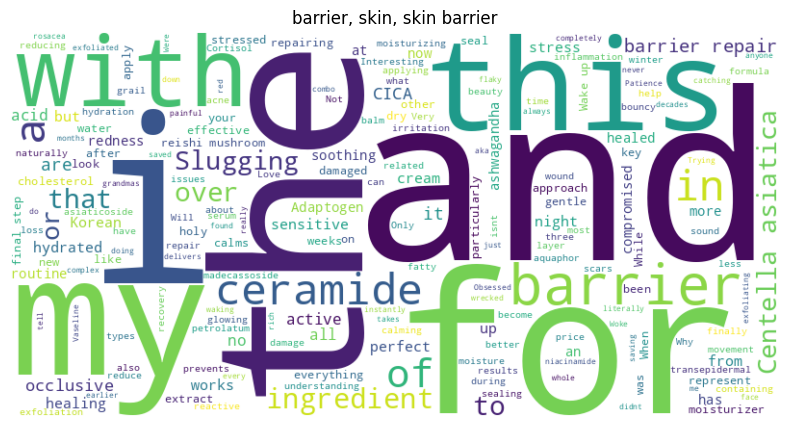

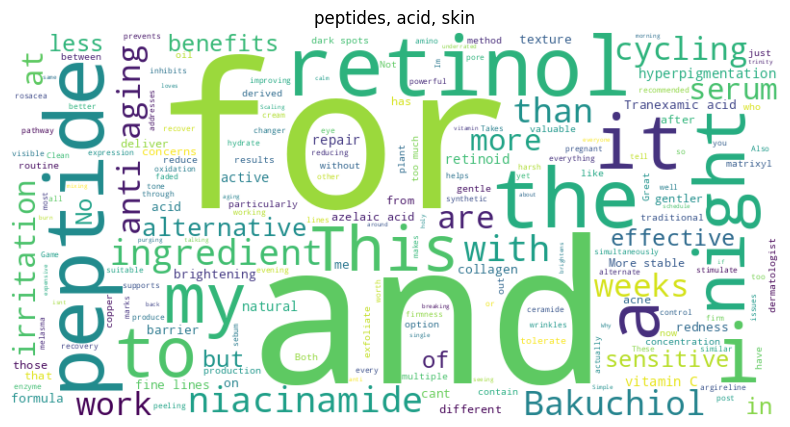

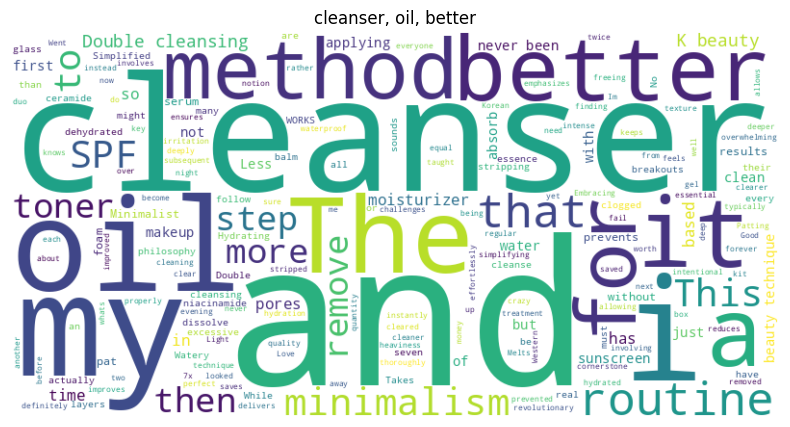

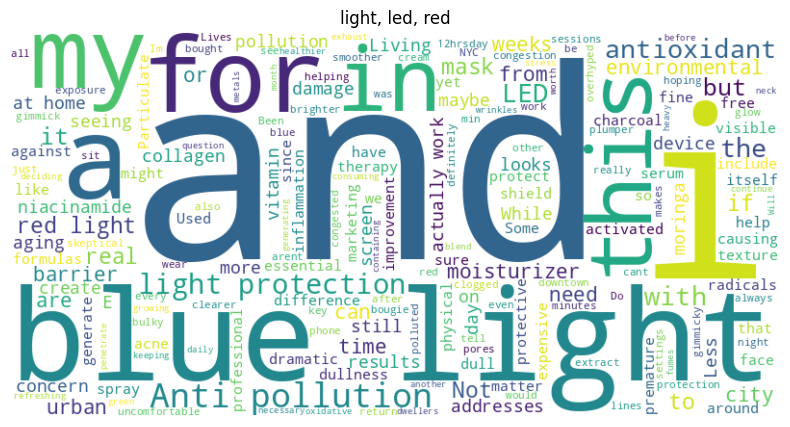

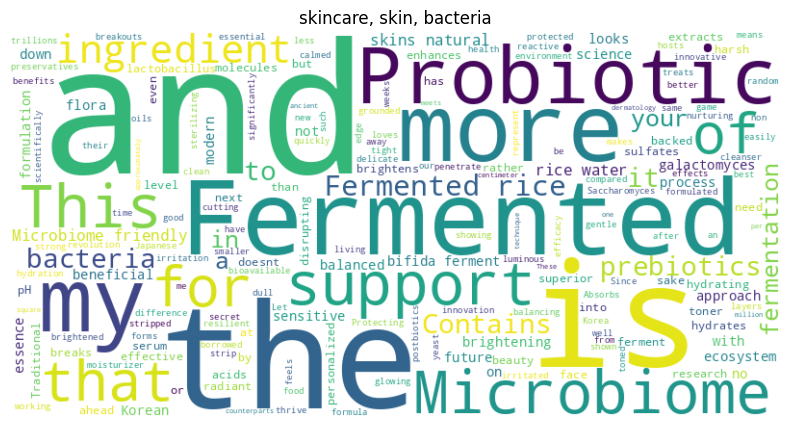

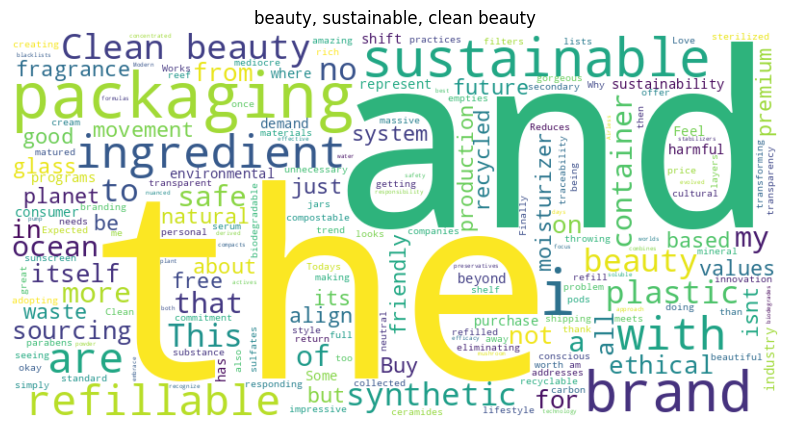

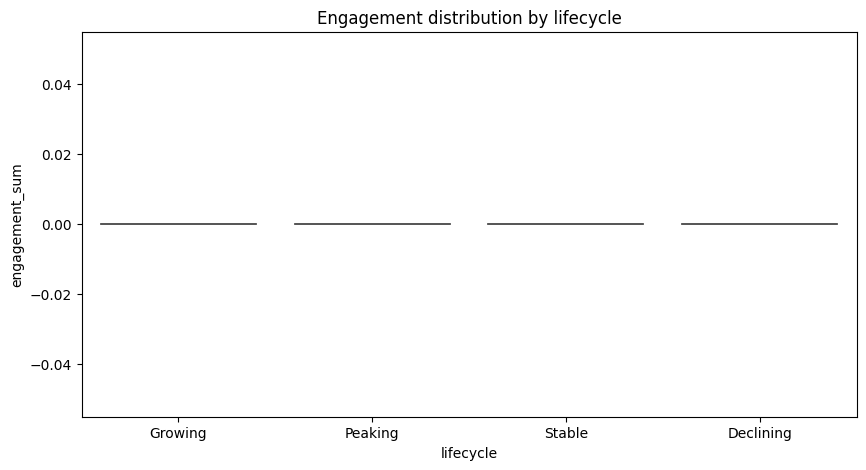

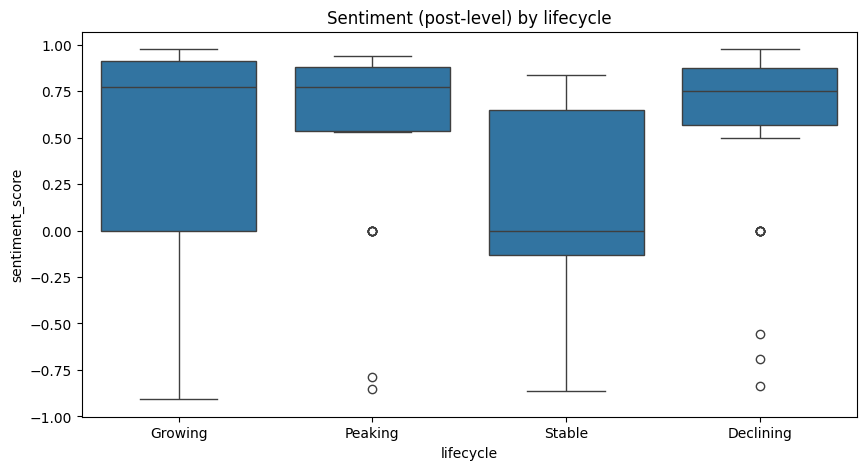

In [ ]:
# Wordcloud for top 6 trends
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud_for_topic(tid, max_words=150):
    texts = df.loc[df[topic_col]==tid, 'text_clean'].tolist()
    if not texts:
        return
    blob  = " ".join(texts)
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                   stopwords=set(['skin','skincare','use','using','product','products'])).generate(blob)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(get_trend_label(tid))
    plt.show()

for tid in signals.sort_values('priority_score', ascending=False).head(6)['topic_bertopic']:
    wordcloud_for_topic(int(tid))

# Sentiment/engagement distributions by lifecycle
import seaborn as sns
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='lifecycle', y='engagement_sum', inner='quart')
plt.title('Engagement distribution by lifecycle')
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='lifecycle', y='sentiment_score')
plt.title('Sentiment (post-level) by lifecycle')
plt.show()

# Bursts for the top-priority trend
def burst_plot_for_topic(tid, pen=3):
    name = get_trend_label(tid)
    g = ts[ts[topic_col]==tid].sort_values('week')
    if g.empty:
        print("No data for topic", tid); return
    counts = g['count'].values
    weeks  = g['week'].astype(str).tolist()
    if len(counts) < 4:
        print("Not enough weeks for burst detection"); return
    algo = rpt.Pelt(model="rbf").fit(counts)
    cps = algo.predict(pen=pen)
    cp_weeks = [weeks[i-1] for i in cps if i-1 < len(weeks)]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=weeks, y=counts, mode='lines+markers', name='count'))
    for w in cp_weeks:
        fig.add_vline(x=w, line_dash='dash', line_color='red')
    fig.update_layout(title=f"Burst detection for {name} (pen={pen})", xaxis=dict(tickangle=45))
    fig.show()

tid_top = int(signals.sort_values('priority_score', ascending=False).iloc[0]['topic_bertopic'])
burst_plot_for_topic(tid_top, pen=3)

# Bipartite network: Trends ↔ Ingredients
import networkx as nx
edges = []
for tid in signals['topic_bertopic'].unique():
    name = get_trend_label(tid)
    ingr = topic_ingredients.get(tid, [])
    for ing in ingr:
        edges.append(('trend:'+name, 'ing:'+ing))
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=42, k=0.8)

trend_nodes = [n for n in G.nodes if n.startswith('trend:')]
ing_nodes   = [n for n in G.nodes if n.startswith('ing:')]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[pos[n][0] for n in ing_nodes], y=[pos[n][1] for n in ing_nodes],
    mode='markers+text', marker=dict(size=8, color='teal'),
    text=[n.replace('ing:','') for n in ing_nodes], textposition='top center',
    name='Ingredient'
))
fig.add_trace(go.Scatter(
    x=[pos[n][0] for n in trend_nodes], y=[pos[n][1] for n in trend_nodes],
    mode='markers+text', marker=dict(size=14, color='orange'),
    text=[n.replace('trend:','') for n in trend_nodes], textposition='bottom center',
    name='Trend'
))
edge_x, edge_y = [], []
for u, v in G.edges():
    edge_x += [pos[u][0], pos[v][0], None]
    edge_y += [pos[u][1], pos[v][1], None]
fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode='lines', line=dict(color='gray', width=1), hoverinfo='none', showlegend=False))
fig.update_layout(title='Bipartite network: Trends ↔ Ingredients', xaxis=dict(visible=False), yaxis=dict(visible=False))
fig.show()
